In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Data.psf import PSF
import lenstronomy.Plots.output_plots as lens_plot
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Plots.output_plots import LensModelPlot
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util

/global/common/cori/software/python/3.6-anaconda-5.2/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in log10


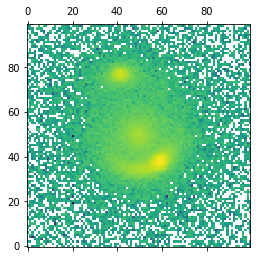

In [4]:
#Lens
lens_model_list = ['SPEP', 'SHEAR']
kwargs_shear = {'e1': 0.01, 'e2': 0.01}  # gamma_ext: shear strength, psi_ext: shear angel (in radian)
kwargs_spemd = {'theta_E': 1., 'gamma': 1.96, 'center_x': 0, 'center_y': 0, 'e1': 0.07, 'e2': -0.03}
kwargs_lens = [kwargs_spemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)
# data specifics
background_rms = .5  # background noise per pixel
exp_time = 100  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  # cutout pixel size
deltaPix = 0.05  # pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.2
#position & solution
ra_source, dec_source = 0.1, 0.3
lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(ra_source, dec_source, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
#source light
source_model_list = ['SERSIC_ELLIPSE']
kwargs_sersic_ellipse = {'amp': 160, 'R_sersic': .5, 'n_sersic': 7, 'center_x': ra_source,
                         'center_y': dec_source, 'e1': 0., 'e2': 0.1}
kwargs_source = [kwargs_sersic_ellipse]
source_model_class = LightModel(light_model_list=source_model_list)
#lens light
lens_light_model_list = ['SERSIC']
kwargs_sersic = {'amp': 400., 'R_sersic': 1., 'n_sersic': 2, 'center_x': 0, 'center_y': 0}
kwargs_lens_light = [kwargs_sersic]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)
#Points source
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image, 'point_amp': np.abs(mag)*100}]  
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
#data
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms, inverse=True)
data_class = ImageData(**kwargs_data)
#PSF
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 3}
psf_class = PSF(**kwargs_psf)
#Image model
imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class, lens_light_model_class,
                                point_source_class, kwargs_numerics=kwargs_numerics)
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps)
#Noise
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
image_sim = image_sim + bkg + poisson

kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)
plt.matshow(np.log10(image_sim), origin='lower')
plt.show()